In [343]:
import ffn
import numpy as np
import pandas as pd
import plotly as py
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
import datetime

import pickle

import xgboost as xgb

from scipy.special import expit, logit
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score,recall_score 

import RegscorePy

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

pd.options.mode.chained_assignment = None

In [58]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

In [59]:
def lin_reg(X_with_bias, y):
    return np.linalg.inv((X_with_bias.T.dot(X_with_bias))).dot(X_with_bias.T.dot(y))
def MSE_(y, y_pred):
    return np.square(np.subtract(y, y_pred)).mean()
def RMSE_(y, y_pred):
    return np.sqrt(np.square(np.subtract(y, y_pred)).mean())
def r2(y, y_pred):
    return np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)

In [60]:
def find_d(data, max_d):
    """
    Used to find degree of differencing to data acheive stationarity.
    """
    min_p = adfuller(data)[1]
    d = 0
    for i in range(1, max_d + 1):
        df = data.diff(periods=i).dropna()
        p = adfuller(df)
        if p[1] < min_p:
            min_p = p[1]
            d = i
    return min_p, d

In [61]:
def BIC(y, y_pred, K):
    """
    Bayesian Information Criterion. 
    """
    n = y.shape[0]
    SSE = np.sum(np.square(y - y_pred))
    return n * np.log(SSE/n) + K * np.log(n)

def AIC(y, y_pred, K):
    """
    Akaike information criterion. 
    """
    n = y.shape[0]
    SSE = np.sum(np.square(y - y_pred))
    return n * np.log(SSE/n) + 2 * K

In [211]:
def AR(data, p, train_ratio=.8):
    """
    Auto Regressive component for ARIMA
    """
    temp = data
    for i in range(p):
        temp['p_deg_%d' % (i+1)] = temp.iloc[:,0].shift(i + 1).values

    train_size = int(train_ratio * temp.shape[0])
    
    df_train = pd.DataFrame(temp[0:train_size]).dropna()

    bias_train = np.ones(shape=(df_train.shape[0], 1))
    X_train = df_train.iloc[:,1:].values.reshape(-1,p)
    X_train = np.hstack((bias_train, X_train))
    y_train = df_train.iloc[:,0].values.reshape(-1,1)

    theta = lin_reg(X_train, y_train)
    df_train['pred_AR'] = X_train.dot(theta)
    
    
    if train_ratio < 1:
        df_test = pd.DataFrame(temp[train_size:])
        bias_test = np.ones(shape=(df_test.shape[0], 1))
        X_test = df_test.iloc[:,1:].values.reshape(-1,p)
        X_test = np.hstack((bias_test, X_test))
        df_test['pred_AR'] = X_test.dot(theta)

        RMSE = np.sqrt(MSE_(df_test.iloc[:,0], df_test['pred_AR']))
        return pd.concat([df_train,df_test]), theta, RMSE
    else:
        RMSE = np.sqrt(MSE_(df_train.iloc[:,0], df_train['pred_AR']))
        return df_train, theta, RMSE

In [212]:
def ARX(data, p, train_ratio=.8):
    """
    Auto regressive component for ARIMAX. Expirimental implementation.
    Exogenous variable is not known the day of price, but can be further autoregressed.
    """
    temp = data
    for i in range(p):
        temp['p_deg_%d' % (i+1)] = temp.iloc[:,0].shift(i + 1).values
        temp['x_deg_%d' % (i+1)] = temp.iloc[:,1].shift(i + 1).values
        
    train_size = int(train_ratio * temp.shape[0])
    
    df_train = pd.DataFrame(temp[0:train_size]).dropna()

    bias_train = np.ones(shape=(df_train.shape[0], 1))
    X_train = df_train.iloc[:,2:].values.reshape(-1, p*2)
    X_train = np.hstack((bias_train, X_train))
    y_train = df_train.iloc[:,0].values.reshape(-1,1)

    theta = lin_reg(X_train, y_train)
    df_train['pred_AR'] = X_train.dot(theta)
    
    if train_ratio < 1:
        df_test = pd.DataFrame(temp[train_size:])
        bias_test = np.ones(shape=(df_test.shape[0], 1))
        X_test = df_test.iloc[:,2:].values.reshape(-1,p*2)
        X_test = np.hstack((bias_test, X_test))
        df_test['pred_AR'] = X_test.dot(theta)

        RMSE = np.sqrt(MSE_(df_test.iloc[:,0], df_test['pred_AR']))
        return pd.concat([df_train,df_test]), theta, RMSE
    else:
        RMSE = np.sqrt(MSE_(df_train.iloc[:,0], df_train['pred_AR']))
        return df_train, theta, RMSE

In [352]:
def ARX(data, p, train_ratio=.8):
    """
    Auto regressive component for ARIMAX. Standard implementation. 
    Exogenous variable is known at time t, works best if it itself is a
    prediction from another model, or exog data is backshifted. 
    """
    temp = data
    for i in range(p):
        temp['p_deg_%d' % (i+1)] = temp.iloc[:,0].shift(i + 1).values
        # temp['x_deg_%d' % (i+1)] = temp.iloc[:,1].shift(i + 1).values
        
    train_size = int(train_ratio * temp.shape[0])
    
    df_train = pd.DataFrame(temp[0:train_size]).dropna()

    bias_train = np.ones(shape=(df_train.shape[0], 1))
    X_train = df_train.iloc[:,1:].values.reshape(-1, p+1)
    X_train = np.hstack((bias_train, X_train))
    y_train = df_train.iloc[:,0].values.reshape(-1,1)

    theta = lin_reg(X_train, y_train)
    df_train['pred_AR'] = X_train.dot(theta)
    
    if train_ratio < 1:
        df_test = pd.DataFrame(temp[train_size:])
        bias_test = np.ones(shape=(df_test.shape[0], 1))
        X_test = df_test.iloc[:,1:].values.reshape(-1,p+1)
        X_test = np.hstack((bias_test, X_test))
        df_test['pred_AR'] = X_test.dot(theta)

        RMSE = np.sqrt(MSE_(df_test.iloc[:,0], df_test['pred_AR']))
        return pd.concat([df_train,df_test]), theta, RMSE
    else:
        RMSE = np.sqrt(MSE_(df_train.iloc[:,0], df_train['pred_AR']))
        return df_train, theta, RMSE

In [213]:
def log_AR(data, p, train_ratio=.8):
    """
    Logistic Auto Regression Compnent for ARIMA. Expirimental.
    """
    temp = data
    for i in range(p):
        temp['p_deg_%d' % (i+1)] = temp.iloc[:,1].shift(i + 1).values

    train_size = int(train_ratio * temp.shape[0])
    
    df_train = pd.DataFrame(temp.iloc[0:train_size, 2:]).dropna()
    y_train = df_train.iloc[:,0].values.reshape(-1,1)
    
    cost_history, theta, predictions = run_log_reg(df_train.to_numpy(), y_train)
    
    out_train =  pd.DataFrame(temp[0:train_size]).dropna()
    out_train['pred_AR'] = predictions
    
    df_test = pd.DataFrame(temp.iloc[train_size:, 2:])
    X = np.hstack((np.ones((df_test.shape[0],1)),df_test.to_numpy()))
    
    out_test = pd.DataFrame(temp.iloc[train_size:,:])
    out_test['pred_AR'] = predict(X, theta)

    RMSE = np.sqrt(MSE_(out_test.iloc[:,0], out_test['pred_AR']))

    return pd.concat([out_train,out_test]), theta, RMSE

In [214]:
def MA(resid, q, train_ratio=.8):
    """
    Moving Average compoent of ARIMA and ARIMAX
    """
    temp = resid
    for i in range(q):
        temp['q_deg_%d' % (i+1)] = temp.iloc[:,0].shift(i + 1).values

    train_size = int(train_ratio * temp.shape[0])
    
    df_train = pd.DataFrame(temp[0:train_size]).dropna()
    df_test = pd.DataFrame(temp[train_size:])

    bias_train = np.ones(shape=(df_train.shape[0], 1))
    X_train = df_train.iloc[:,1:].values.reshape(-1,q)
    X_train = np.hstack((bias_train, X_train))
    y_train = df_train.iloc[:,0].values.reshape(-1,1)

    theta = lin_reg(X_train, y_train)
    df_train['pred_MA'] = X_train.dot(theta)
    
    bias_test = np.ones(shape=(df_test.shape[0], 1))
    X_test = df_test.iloc[:,1:].values.reshape(-1,q)
    X_test = np.hstack((bias_test, X_test))
    df_test['pred_MA'] = X_test.dot(theta)

    RMSE = np.sqrt(MSE_(df_test.iloc[:,0], df_test['pred_MA']))
    
    df_train.drop(columns=['resid'], inplace=True)
    df_test.drop(columns=['resid'], inplace=True)
    return pd.concat([df_train,df_test]), theta, RMSE

In [215]:
def ARIMA(data, p, d, q, train_ratio=.8):
    """
    Combining AR and MA. 
    """
    if d > 0:
        df = data.diff(periods=d)
    else:
        df = data.copy()
    df_AR, theta_AR, RMSE_AR = AR(df, p, train_ratio=train_ratio)
    df_AR['resid'] = df_AR.iloc[:, 0].values - df_AR['pred_AR'].values
    df_MA, theta_MA, RMSE_MA = MA(df_AR[['resid']], q, train_ratio=train_ratio)
    return pd.merge(df_AR, df_MA, on='date', how='outer'), theta_AR, theta_MA

In [216]:
def ARIMAX(data, p, d, q, train_ratio=.8):
    """
    Combining AR and MA with exogenous regressor.
    """
    if d > 0:
        df = data.diff(periods=d)
    else:
        df = data.copy()
    df_AR, theta_AR, RMSE_AR = ARX(df, p, train_ratio=train_ratio)
    df_AR['resid'] = df_AR.iloc[:, 0].values - df_AR['pred_AR'].values
    df_MA, theta_MA, RMSE_MA = MA(df_AR[['resid']], q, train_ratio=train_ratio)
    return pd.merge(df_AR, df_MA, on='date', how='outer'), theta_AR, theta_MA

In [68]:
def bin_ARI(data, p, d, train_ratio=.8):
    """
    Combinng Logistic AR and standard MA components. Expirimental.
    0 col : y
    1 col : X
    """
    if d > 0:
        df = data.copy()
        df.iloc[:, 1] = data.iloc[:, 1] - data.iloc[:, 1].shift(d)
        df.dropna(inplace=True)
    else: 
        df = data.copy()
    df_AR, theta_AR, RMSE_AR = log_AR(df, p, train_ratio=train_ratio)
    return df_AR, theta_AR

In [70]:
def auto_ARIMA(X, percent_training=.8, max_p=12, max_d=12, max_q=12, data_name='eur_usd', verbose=True, criterion='AIC'):
    if criterion not in ['AIC', 'BIC', 'RMSE']:
        raise ValueError('Only AIC, BIC, and RMSE currently supported')
    
    data_train = X.iloc[0: int(percent_training * X.shape[0]), :]
    data_test = X.iloc[int(percent_training * X.shape[0]):, : ]
    
    min_p, d = find_d(data_train, max_d)
    
    if verbose == True:
        ACF = plot_acf(data_train.dropna(),lags=50)
        PACF = plot_pacf(data_train.dropna(),lags=50)
    
    min_bic, min_aic, min_rmse = float('inf'), float('inf'), float('inf')
    P, D, Q = 0, d, 0
    p_bic, d_bic, q_bic = 0, d, 0
    p_aic, d_aic, q_aic = 0, d, 0
    p_rmse, d_rmse, q_rmse = 0, d, 0
    
    final_data = None
    
    for i in range(1, max_p + 1):
        for j in range(1, max_q + 1):
            data_out, theta_AR, theta_MA = ARIMA(X[[data_name]], i, d, j, train_ratio=percent_training)
            data_out = data_out.dropna()
            data_out['pred_total'] = data_out['pred_AR'].values + data_out['pred_MA'].values
            
            price = X[[data_name]]
            price.rename(columns={data_name:'price'}, inplace=True)
            price = pd.merge(price, data_out[[data_name, 'pred_total']], on='date', how='outer')
            if d > 0:
                price[data_name] = price[data_name].values + price['price'].shift(d).values
                price['pred_total'] = price['pred_total'].values + price['price'].shift(d).values
            price = price.dropna()
            
            bic = BIC(price[data_name], price['pred_total'], i + j)
            aic = AIC(price[data_name], price['pred_total'], i + j)
            rmse = RMSE_(price[data_name], price['pred_total'])
            
            if bic < min_bic:
                min_bic = bic
                p_bic = i
                q_bic = j
                if criterion == 'BIC':
                    final_data=price
                
            if aic < min_aic:
                min_aic = aic
                p_aic = i
                q_aic = j
                if criterion == 'AIC':
                    final_data=price
                
            if rmse < min_rmse:
                min_rmse = rmse
                p_rmse = i
                q_rmse = j
                if criterion == 'RMSE':
                    final_data=price
    
    if verbose == True:
        print("BIC --- p: ", p_bic, " d: ", d_bic, " q: ", q_bic, ' BIC: ', min_bic)
        print("AIC --- p: ", p_aic, " d: ", d_aic, " q: ", q_aic, ' AIC: ', min_aic)
        print("RMSE --- p: ", p_rmse, " d: ", d_rmse, " q: ", q_rmse, ' RMSE: ', min_rmse)
    
    if criterion == 'BIC':
        return p_bic, d, q_bic, min_bic, final_data
    elif criterion == 'AIC':
        return p_aic, d, q_aic, min_aic, final_data
    else:
        return p_rmse, d, q_rmse, min_rmse, final_data

In [71]:
def auto_ARIMAX(X, exog_name, percent_training=.8, max_p=12, max_d=12, max_q=12, data_name='eur_usd', verbose=True, criterion='AIC'):
    if criterion not in ['AIC', 'BIC', 'RMSE']:
        raise ValueError('Only AIC, BIC, and RMSE currently supported')
    
    data_train = X.iloc[0: int(percent_training * X.shape[0]), :]
    data_test = X.iloc[int(percent_training * X.shape[0]):, : ]
    
    min_p, d = find_d(data_train.iloc[:, 0], max_d)
    
    if verbose == True:
        ACF = plot_acf(data_train.iloc[:, 0].dropna(),lags=50)
        PACF = plot_pacf(data_train.iloc[:, 0].dropna(),lags=50)
    
    min_bic, min_aic, min_rmse = float('inf'), float('inf'), float('inf')
    P, D, Q = 0, d, 0
    p_bic, d_bic, q_bic = 0, d, 0
    p_aic, d_aic, q_aic = 0, d, 0
    p_rmse, d_rmse, q_rmse = 0, d, 0
    
    final_data = None
    
    for i in range(1, max_p + 1):
        for j in range(1, max_q + 1):
            data_out, theta_AR, theta_MA = ARIMAX(X[[data_name, exog_name]], i, d, j, train_ratio=percent_training)
            data_out = data_out.dropna()
            data_out['pred_total'] = data_out['pred_AR'].values + data_out['pred_MA'].values
            
            price = X[[data_name, exog_name]]
            price.rename(columns={data_name:'endog', exog_name:'exog'}, inplace=True)
            price = pd.merge(price, data_out[[data_name, exog_name, 'pred_total']], on='date', how='outer')
            if d > 0:
                price[data_name] = price[data_name].values + price['endog'].shift(d).values
                price[exog_name] = price[exog_name].values + price['exog'].shift(d).values
                price['pred_total'] = price['pred_total'].values + price['endog'].shift(d).values
            price = price.dropna()
            
            bic = BIC(price[data_name], price['pred_total'], i + j)
            aic = AIC(price[data_name], price['pred_total'], i + j)
            rmse = RMSE_(price[data_name], price['pred_total'])
            
            if bic < min_bic:
                min_bic = bic
                p_bic = i
                q_bic = j
                if criterion == 'BIC':
                    final_data=price
                
            if aic < min_aic:
                min_aic = aic
                p_aic = i
                q_aic = j
                if criterion == 'AIC':
                    final_data=price
                
            if rmse < min_rmse:
                min_rmse = rmse
                p_rmse = i
                q_rmse = j
                if criterion == 'RMSE':
                    final_data=price
    
    if verbose == True:
        print("BIC --- p: ", p_bic, " d: ", d_bic, " q: ", q_bic, ' BIC: ', min_bic)
        print("AIC --- p: ", p_aic, " d: ", d_aic, " q: ", q_aic, ' AIC: ', min_aic)
        print("RMSE --- p: ", p_rmse, " d: ", d_rmse, " q: ", q_rmse, ' RMSE: ', min_rmse)
    
    if criterion == 'BIC':
        return p_bic, d, q_bic, min_bic, final_data
    elif criterion == 'AIC':
        return p_aic, d, q_aic, min_aic, final_data
    else:
        return p_rmse, d, q_rmse, min_rmse, final_data

In [298]:
def train_as_go_ARIMA(X, p, d, q, start_point=.8, data_name='eur_usd'):
    X['rt_out'] = np.zeros(X.shape[0])
    point = int(start_point * X.shape[0])
    for i in range(point, X.shape[0]):
        idx = X.iloc[i].name
        data_out, theta_AR, theta_MA = ARIMA(X[[data_name]], p, d, q, train_ratio=(point/X.shape[0]))
        data_out = data_out.dropna()
        data_out['pred_total'] = data_out['pred_AR'].values + data_out['pred_MA'].values

        price = X[[data_name]]
        price.rename(columns={data_name:'price'}, inplace=True)
        price = pd.merge(price, data_out[[data_name, 'pred_total']], on='date', how='outer')
        if d > 0:
            price[data_name] = price[data_name].values + price['price'].shift(d).values
            price['pred_total'] = price['pred_total'].values + price['price'].shift(d).values
            price = price.dropna()
        X.loc[idx, 'rt_out'] = price.loc[idx, 'pred_total']
    return X

In [303]:
def train_as_go_ARIMAX(X, p, d, q, start_point=.8, data_name='eur_usd', exog_name='GAX'):
    X['rt_out'] = np.zeros(X.shape[0])
    point = int(start_point * X.shape[0])
    for i in range(point, X.shape[0]):
        idx = X.iloc[i].name       
        data_out, theta_AR, theta_MA = ARIMAX(X[[data_name, exog_name]], p, d, q, train_ratio=(point/X.shape[0]))
        data_out = data_out.dropna()
        data_out['pred_total'] = data_out['pred_AR'].values + data_out['pred_MA'].values

        price = X[[data_name, exog_name]]
        price.rename(columns={data_name:'endog', exog_name:'exog'}, inplace=True)
        price = pd.merge(price, data_out[[data_name, exog_name, 'pred_total']], on='date', how='outer')
        if d > 0:
            price[data_name] = price[data_name].values + price['endog'].shift(d).values
            price[exog_name] = price[exog_name].values + price['exog'].shift(d).values
            price['pred_total'] = price['pred_total'].values + price['endog'].shift(d).values
            price = price.dropna()
        X.loc[idx, 'rt_out'] = price.loc[idx, 'pred_total']
    return X

In [394]:
def get_dir(auto_out, x_name='eur_usd', pred_name='pred_total', train_portion=.8):
    auto_out['yesterday'] = auto_out[x_name].shift(1).values
    auto_out['dir'] = np.where(auto_out[x_name].values - auto_out['yesterday'].values > 0, 1, 0)
    auto_out['dir_pred'] = np.where(auto_out[pred_name].values - auto_out['yesterday'].values > 0, 1, 0)
    a = auto_out.dropna()
    a['correct'] = np.where(a['dir'].values == a['dir_pred'].values, 1, 0)
    print("Correct direction percent: ", np.sum(a.iloc[int(train_portion * a.shape[0]):]['correct']) / a.iloc[int(train_portion * a.shape[0]):].shape[0])
    print("RMSE: ", RMSE_(a.iloc[int(train_portion * a.shape[0]):][x_name], a.iloc[int(train_portion * a.shape[0]):][pred_name]))
    plot = ConfusionMatrixDisplay(confusion_matrix(a.iloc[int(train_portion * a.shape[0]):]['dir'], a.iloc[int(train_portion * a.shape[0]):]['dir_pred']), display_labels=['down', 'up'])
    plot.plot()
    return a

In [181]:
def plot_roc(X, y):
    fpr, tpr, _ = roc_curve(X, y)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [315]:
def back_test(data, percent_train=.8, pred_dir_label='dir_pred', y_label='eur_usd'):
    """
    Simple backtest for given data. No commisions, assuming buy and sell at exact price.
    """
    
    if 'yesterday' not in data.columns:
        data['yesterday'] = data[y_label].shift(1).values
        data = data.dropna()
    test = data[int(data.shape[0] * percent_train):]
    
    test['gains'] = np.where(test[pred_dir_label] > 0.001, test['eur_usd']/test['yesterday'], 0)
    test['shorts'] = np.where(test[pred_dir_label] < .999, test['eur_usd']/test['yesterday'], 0)
    test['holds'] = test['eur_usd'].values / test['yesterday'].values
    
    gain = 100
    hold = 100
    gains = []
    holds = []
    for i in range(test.shape[0]):
        if test.iloc[i]['gains'] > 0.000001:
            if test.iloc[i]['shorts'] > 0.000001:
                raise ValueError('buying and shorting on same day')
            gain = gain * test.iloc[i]['gains']
        elif test.iloc[i]['shorts'] > 0.000001:
            bought = test.iloc[i - 1]['eur_usd'] * gain
            gain += (bought - (test.iloc[i]['shorts'] * bought))   
        gains.append(gain)

    for ratio in test['holds'].values:
        hold = hold * ratio
        holds.append(hold)
    test['gain'] = gains
    test['hold'] = holds
    test[['gain', 'hold']].plot(figsize=(15, 10))
    return test

In [69]:
"""
Logistic Regression Components used to make a possible ARIMAX exogenous variable
"""


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_cost(X, y, theta):
    """
    Cost for logistic regression
    """
    m = len(y)
    h = sigmoid(X @ theta)
    epsilon = 1e-5
    cost = (1/m)*(((-y).T @ np.log(h + epsilon))-((1-y).T @ np.log(1-h + epsilon)))
    return cost

def gradient_descent(X, y, params, learning_rate, iterations):
    """
    Gradient decent for logistic regression
    """
    m = len(y)
    cost_history = np.zeros((iterations,1))

    for i in range(iterations):
        params = params - (learning_rate/m) * (X.T @ (sigmoid(X @ params) - y)) 
        cost_history[i] = compute_cost(X, y, params)

    return cost_history, params

def predict(X, params):
    return sigmoid(X @ params)

import seaborn as sns
import matplotlib.pyplot as plt

def run_log_reg(X, y, iterations = 1500, learning_rate = 0.03):
    m = len(y)

    X = np.hstack((np.ones((m,1)),X))
    n = np.size(X,1)
    params = np.zeros((n,1))

    cost_history, params = gradient_descent(X, y, params, learning_rate, iterations)
    predictions =  predict(X, params)
    
    plt.figure()
    sns.set_style('white')
    plt.plot(range(len(cost_history)), cost_history, 'r')
    plt.title("Convergence Graph of Cost Function")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show()
    
    
    return cost_history, params, predictions

In [78]:
"""
US Data
"""
data = pd.read_csv('Data/us_daily_data.csv')
data['timestamp'] = data['date'].apply(lambda x: int(pd.Timestamp(x).timestamp()))
data.set_index('date', inplace=True)
data

m6 yield  y5 yield  y10 yield         spy   eur_usd       CPI  \
date                                                                        
2004-01-01      1.02      3.25       4.27   79.088287  1.258194  1.926252   
2004-01-02      1.02      3.36       4.38   79.052704  1.258194  1.926252   
2004-01-05      1.05      3.39       4.41   79.912697  1.268698  1.926252   
2004-01-06      1.03      3.26       4.29   79.990868  1.272103  1.926252   
2004-01-07      1.02      3.25       4.27   80.260941  1.264095  1.926252   
...              ...       ...        ...         ...       ...       ...   
2021-03-04      0.07      0.77       1.54  375.470245  1.205066  1.399770   
2021-03-05      0.07      0.79       1.56  382.377625  1.196774  1.399770   
2021-03-08      0.06      0.86       1.59  380.473846  1.192563  1.399770   
2021-03-09      0.07      0.83       1.55  385.906067  1.185171  1.399770   
2021-03-10      0.06      0.80       1.53  388.308197  1.189791  1.399770   

                 GDP  FFER         y  class  dir   timestamp  
date                                                          
2004-01-01  0.533747  0.96  1.258194     30  0.0  1072915200  
2004-01-02  0.533747  0.96  1.268698     40  1.0  1073001600  
2004-01-05  0.533747  0.96  1.272103     40  1.0  1073260800  
2004-01-06  0.533747  0.96  1.264095     40 -1.0  1073347200  
2004-01-07  0.533747  0.97  1.277498     40  1.0  1073433600  
...              ...   ...       ...    ...  ...         ...  
2021-03-04  1.007613  0.07  1.196774     20 -1.0  1614816000  
2021-03-05  1.007613  0.07  1.192563     20 -1.0  1614902400  
2021-03-08  1.007613  0.07  1.185171     20 -1.0  1615161600  
2021-03-09  1.007613  0.07  1.189791     20  1.0  1615248000  
2021-03-10  1.007613  0.07  1.192606     20  1.0  1615334400  

[3925 rows x 12 columns]

In [335]:
"""
Adding Euro Zone economic data.
"""
df = pd.read_csv('Data/EU/full_data.csv')
df = df.dropna()
df['date'] = pd.to_datetime(df['date']).values
df.drop(columns=['eur_usd'])
df.set_index('date', inplace=True)
data.reset_index(inplace=True)
data['date'] = pd.to_datetime(data['date']).values
both = pd.merge(data, df, on='date', how='outer')
both = both.dropna()
# both.drop(columns=['level_0', 'index', 'eur_usd_y'], inplace=True)
both.set_index('date', inplace=True)
data.set_index('date', inplace=True)

both.rename(columns={'y5 yield_x':'y5_yeild_us', 
             'y10 yield_x':'y10_yeild_us', 
             'm6 yield':'m6_yeild_us', 
             'y2 yield':'y2_yeild_eu', 
             'y5 yield_y':'y5_yeild_eu', 
             'y10 yield_y':'y10_yeild_eu', 'eur_usd_x':'eur_usd'}, inplace=True)

both['y5_ratio'] = both['y5_yeild_eu'].values / both['y5_yeild_us'].values
both['y10_ratio'] = both['y10_yeild_eu'].values / both['y10_yeild_us'].values

both['day'] = both.index.dayofyear
both['day_of_week'] = both.index.dayofweek
both['day_next'] = both.index.dayofweek
both['day_next'] = both['day_next'].shift(-1)
both.at['2020-09-30', 'day_next'] = 3.0
both['day_next'] = both['day_next'].values.astype('int32')

both['yesterday'] = both['eur_usd'].shift(1).values
both.dropna(inplace=True)
both['dir'] = np.where(both['eur_usd'].values > both['yesterday'].values, 1, 0)

for i in range(12):
    both['ar_deg_%d' % (i+1)] = both['eur_usd'].shift(i + 1).values

ACF/PACF plots for EUR-USD and differecnced EUR-USD. Degree:  1  P-val:  0.0


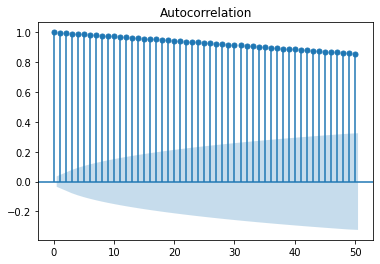

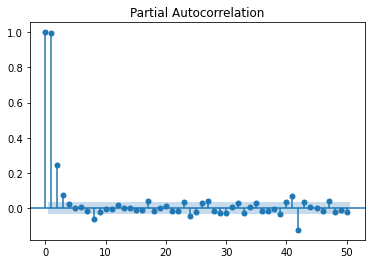

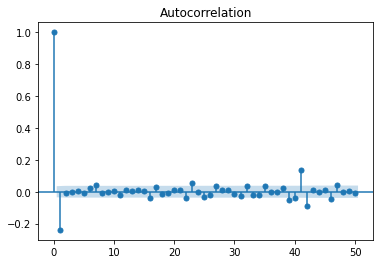

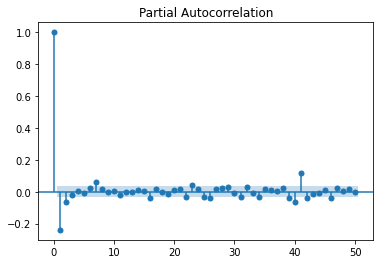

In [366]:
"""
Plotting Autocorrelation/ Partial Autocorrelation tables.
"""

X = data[['eur_usd']]
p_val, d = find_d(X, max_d=15)
data_train = X.iloc[0: int(.8 * X.shape[0]), :]
data_test = X.iloc[int(.8 * X.shape[0]):, : ]

print("ACF/PACF plots for EUR-USD and differecnced EUR-USD. Degree: ", d, " P-val: ", p_val)
ACF = plot_acf(data_train.dropna(),lags=50)
PACF = plot_pacf(data_train.dropna(),lags=50)

ACF = plot_acf(data_train.diff(periods=d).dropna(),lags=50)
PACF = plot_pacf(data_train.diff(periods=d).dropna(),lags=50)

<AxesSubplot:xlabel='date'>

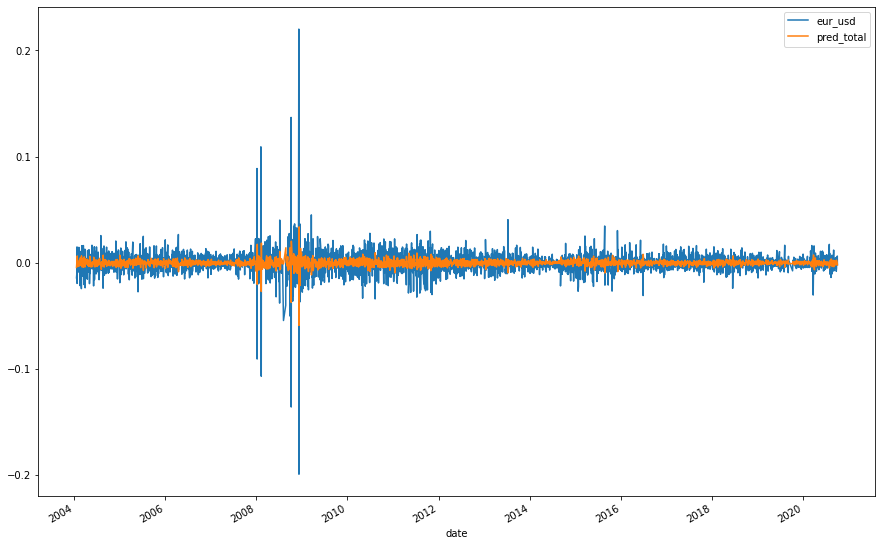

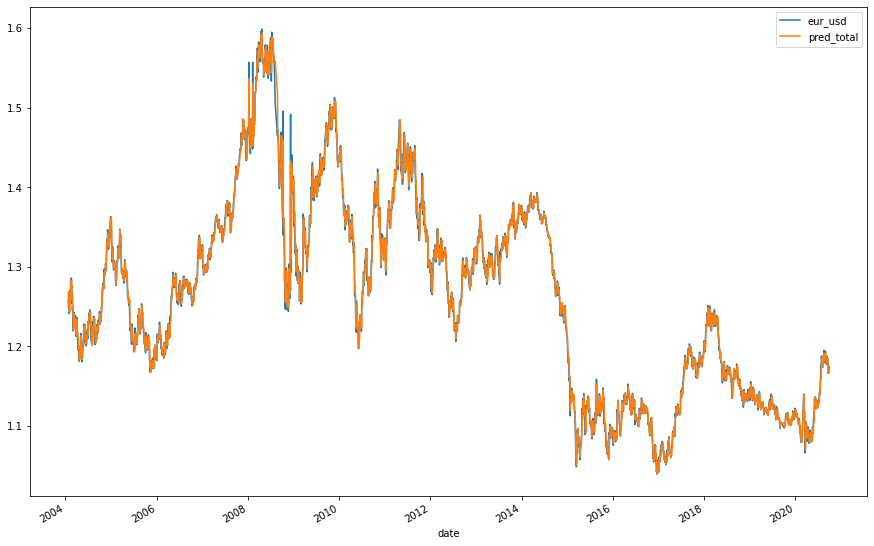

In [55]:
"""
ARIMA function demonstration. 
"""

data_out, theta_AR, theta_MA = ARIMA(both[['eur_usd']], 12, d, 2)
data_out = data_out.dropna()
data_out['pred_total'] = data_out['pred_AR'].values + data_out['pred_MA'].values

data_out[['eur_usd', 'pred_total']].plot(figsize=(15, 10))

price = both[['eur_usd']]
price.rename(columns={'eur_usd':'price'}, inplace=True)
price = pd.merge(price, data_out[['eur_usd', 'pred_total']], on='date', how='outer')
price['eur_usd'] = price['eur_usd'].values + price['price'].shift(d).values
price['pred_total'] = price['pred_total'].values + price['price'].shift(d).values

price = price.dropna()
price[['eur_usd', 'pred_total']].plot(figsize=(15, 10))

BIC --- p:  1  d:  1  q:  1  BIC:  -35988.50289376848
AIC --- p:  1  d:  1  q:  2  AIC:  -36004.26345887603
RMSE --- p:  11  d:  1  q:  8  RMSE:  0.010102498713339965
RMSE:  0.010132832069384494


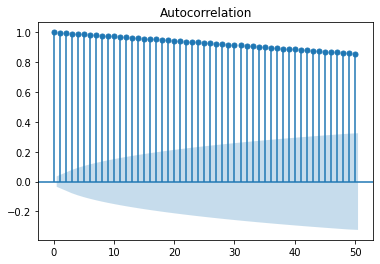

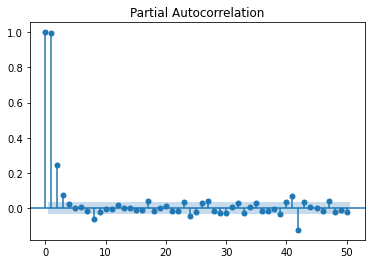

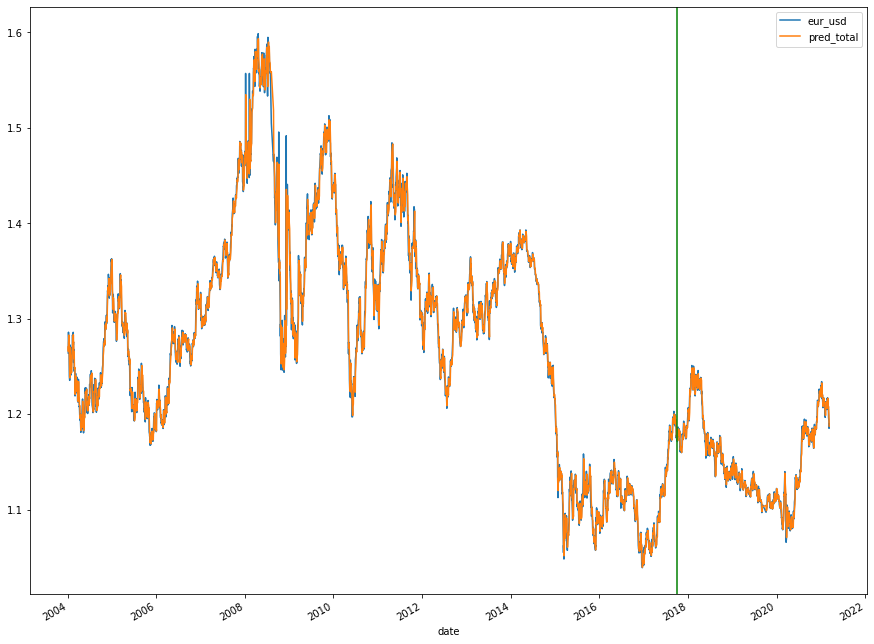

In [301]:
"""
Auto ARIMA demonstration.
"""
train_portion = .8
p, d, q, bic, auto_out = auto_ARIMA(data[['eur_usd']], percent_training=train_portion)

auto_out[['eur_usd', 'pred_total']].plot(figsize=(15, 12)).axvline(x = auto_out.index[int(auto_out.shape[0] * train_portion)], color='green')
print("RMSE from chosen: ", RMSE_(auto_out['eur_usd'], auto_out['pred_total']))

<AxesSubplot:xlabel='date'>

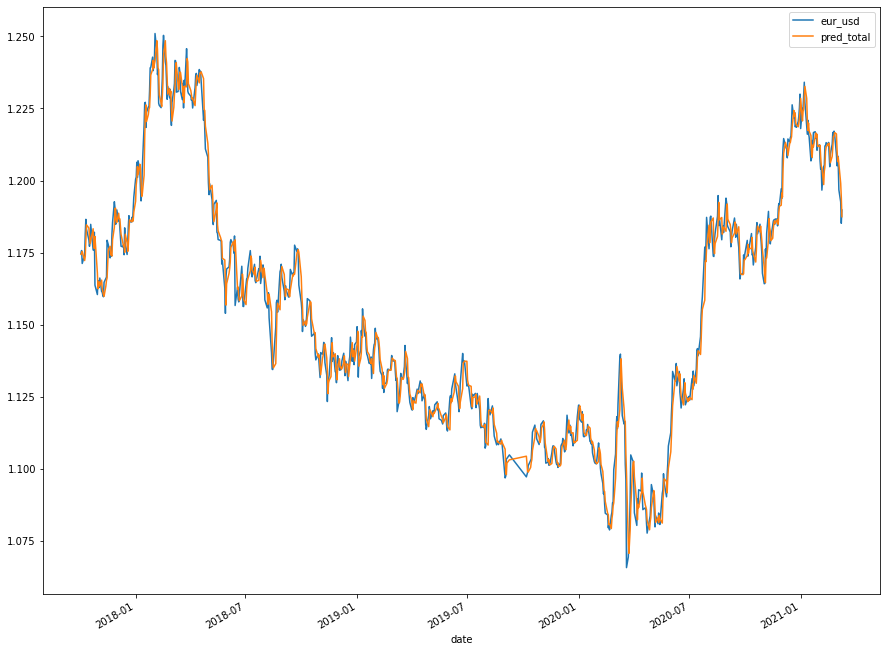

In [368]:
auto_out[['eur_usd', 'pred_total']].iloc[int(train_portion * auto_out.shape[0]):].plot(figsize=(15, 12))

0.005327868707296248


<AxesSubplot:xlabel='date'>

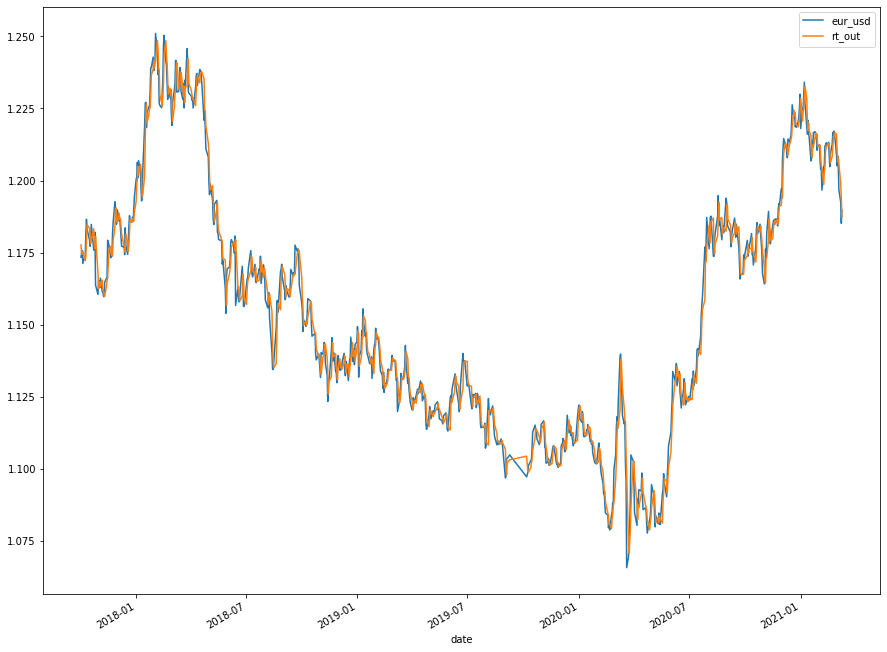

In [299]:
"""
ARIMA retrained before every prediction. 
"""
tag_out = train_as_go_ARIMA(data[['eur_usd']], 1, 1, 2)
tag_out = tag_out.iloc[int(train_portion * tag_out.shape[0]):]
tag_out[['eur_usd', 'rt_out']].plot(figsize=(15, 12))
print("RMSE: ", RMSE_(tag_out['eur_usd'], tag_out['rt_out']))

BIC --- p:  7  d:  3  q:  10  BIC:  -33233.06544558566
AIC --- p:  10  d:  3  q:  12  AIC:  -33367.15490958953
RMSE --- p:  10  d:  3  q:  12  RMSE:  0.010770542106198492


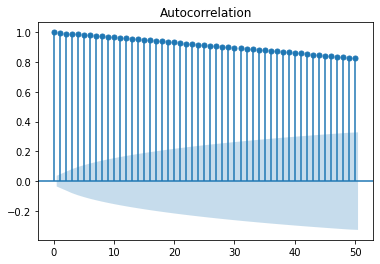

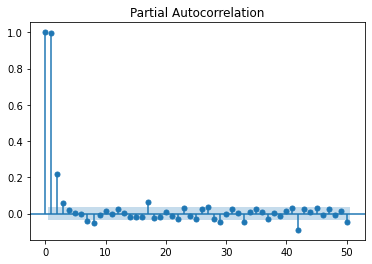

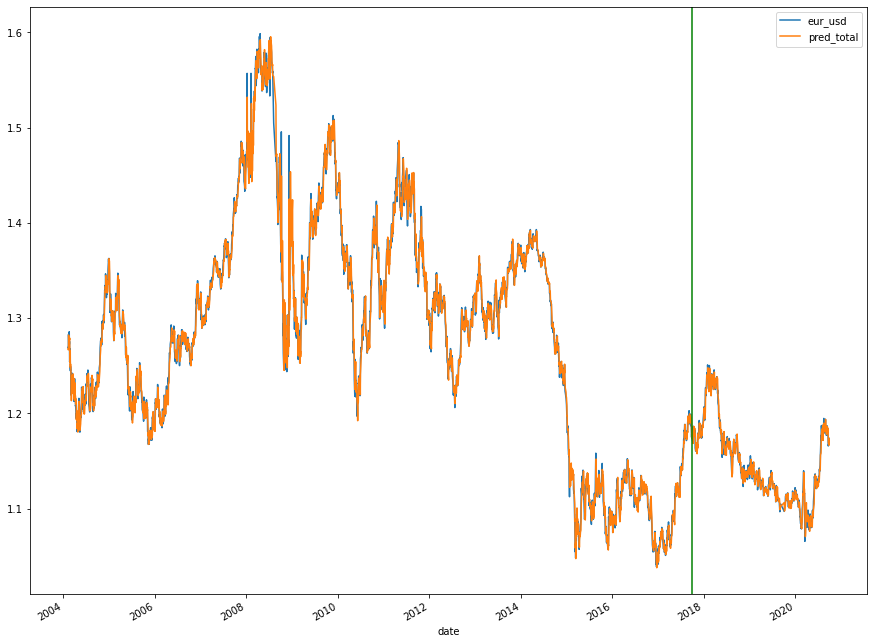

In [388]:
p2, d2, q2, bic2, auto_out2 = auto_ARIMAX(both[['eur_usd', 'day_of_week']], exog_name='day_of_week', percent_training=train_portion)
auto_out2[['eur_usd', 'pred_total']].plot(figsize=(15, 12)).axvline(x = auto_out.index[int(auto_out.shape[0] * train_portion)], color='green')

BIC --- p:  7  d:  3  q:  10  BIC:  -33233.103927714816
AIC --- p:  10  d:  3  q:  12  AIC:  -33366.45255514526
RMSE --- p:  10  d:  3  q:  12  RMSE:  0.010771568021358214
0.010771568021358214


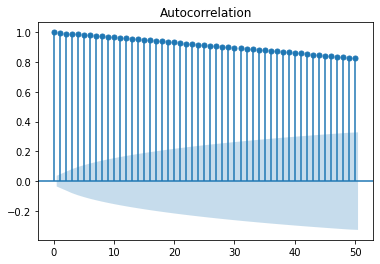

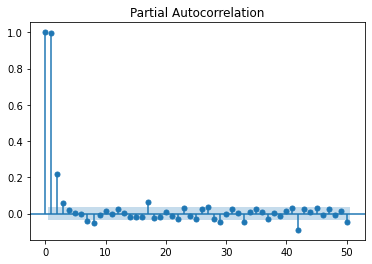

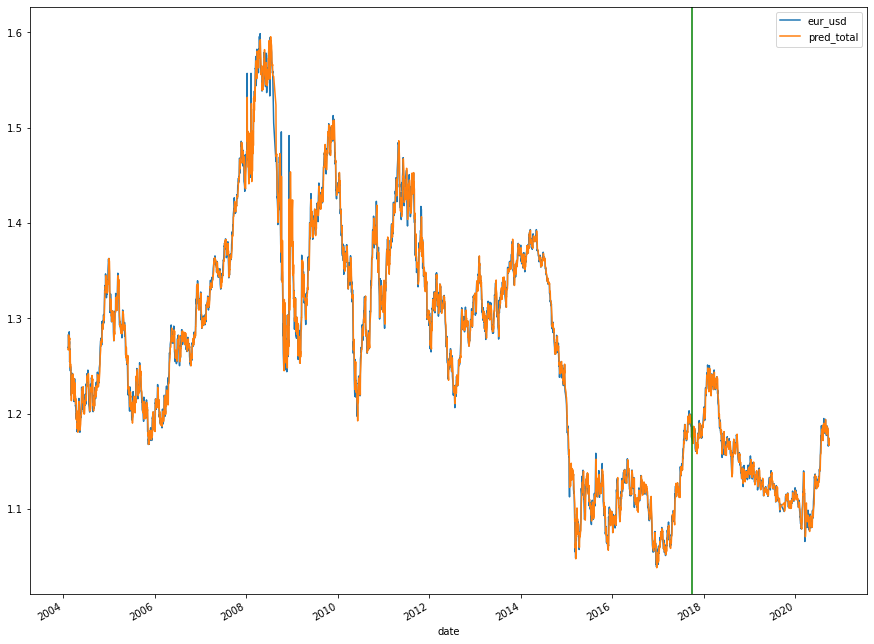

In [397]:
p2, d2, q2, bic2, auto_out2 = auto_ARIMAX(both[['eur_usd', 'GAX_volume']], exog_name='GAX_volume', percent_training=train_portion)
auto_out2[['eur_usd', 'pred_total']].plot(figsize=(15, 12)).axvline(x = auto_out.index[int(auto_out.shape[0] * train_portion)], color='green')
print(RMSE_(auto_out2['eur_usd'], auto_out2['pred_total']))

In [398]:
RMSE_(auto_out2['eur_usd'].iloc[int(.8 * auto_out2.shape[0])], auto_out2['pred_total'].iloc[int(.8 * auto_out2.shape[0])])

0.010931690084239554

ARIMAX GAX VOLUME
BIC --- p:  6  d:  5  q:  10  BIC:  -32931.210681610995
AIC --- p:  6  d:  5  q:  11  AIC:  -33034.87556996395
RMSE --- p:  9  d:  5  q:  12  RMSE:  0.011297686700677916

<AxesSubplot:ylabel='dir'>

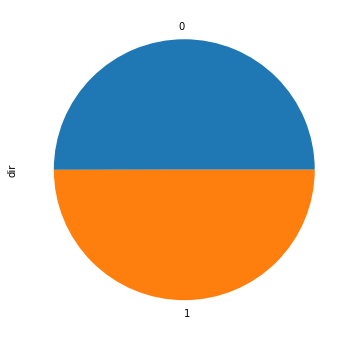

In [98]:
auto_out['dir'].value_counts().plot.pie(figsize=(6,6))
# auto_out['dir_pred'].value_counts().plot.pie(figsize=(6,6))

Correct direction percent:  0.48214285714285715
RMSE:  0.005329050020163918


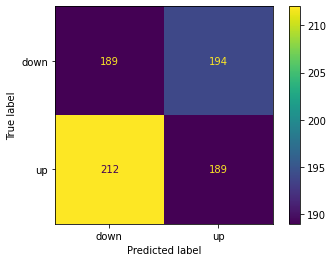

In [395]:
auto_out = get_dir(auto_out, train_portion=.8)

Correct direction percent:  0.4932249322493225
RMSE:  0.005908636753174468


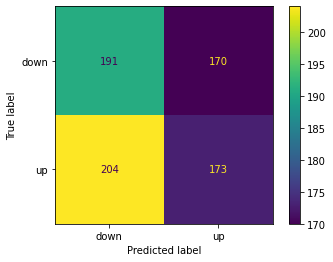

In [399]:
auto_out2 = get_dir(auto_out2, train_portion=.8)

Correct direction percent:  0.48148148148148145
RMSE:  0.005332436638985006


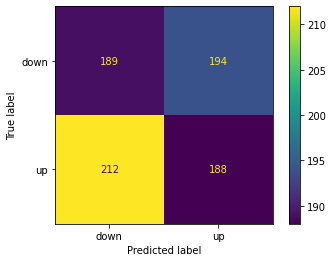

In [369]:
tag_out = get_dir(tag_out, pred_name='rt_out', train_portion=0)

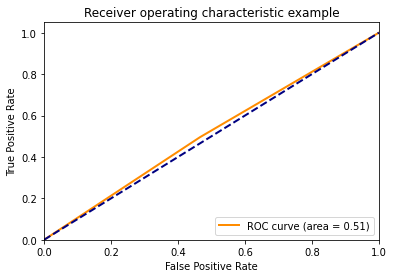

In [312]:
plot_roc(auto_out2['dir'], auto_out2['dir_pred'])

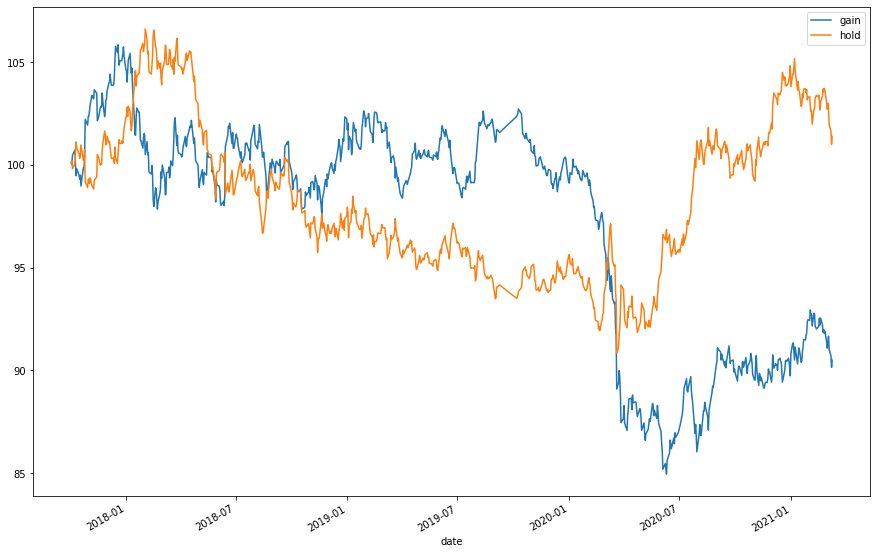

In [320]:
ao_bt = back_test(auto_out)

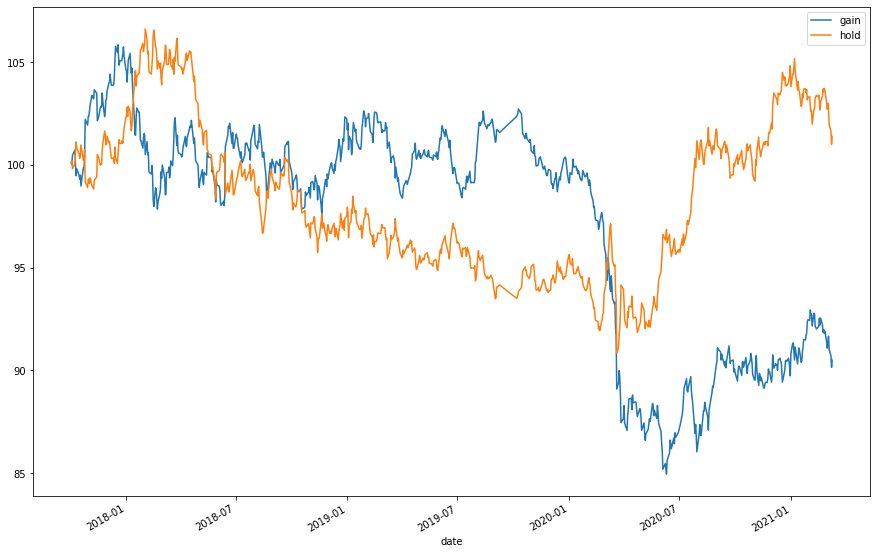

In [327]:
td_bt = back_test(tag_out, percent_train=0)

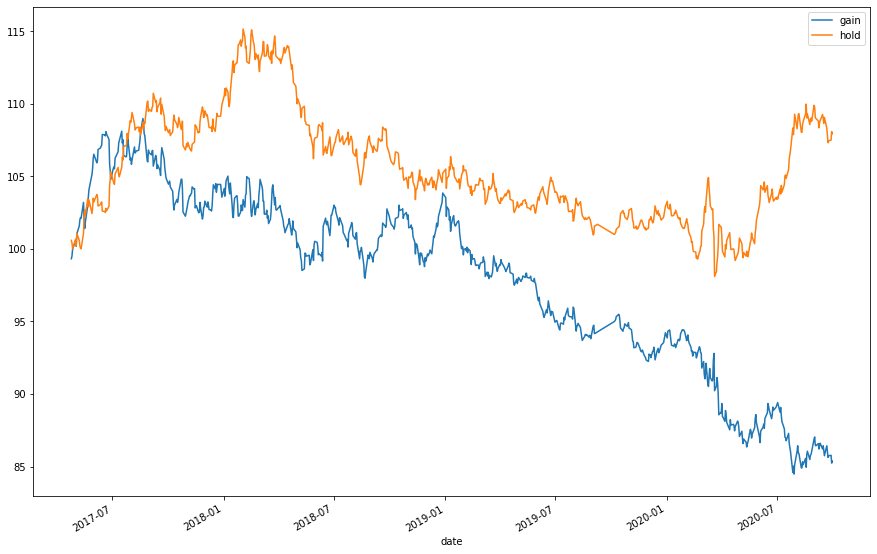

In [328]:
ao_bt = back_test(auto_out2)

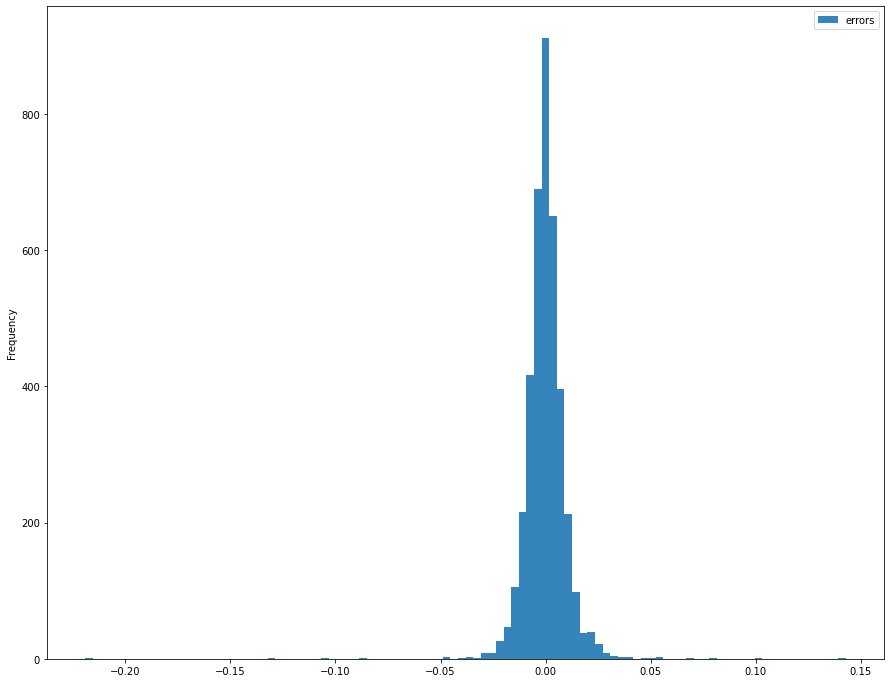

In [374]:
auto_out['errors'] = auto_out['pred_total'].values - auto_out['eur_usd'].values
ax = auto_out[['errors']].plot.hist(bins=100, figsize=(15, 12), alpha=.9)
# auto_out2[['errors']].plot.kde(ax=ax, secondary_y=True, figsize=(15, 12))

In [336]:
y_dir = both[['dir']]
y_price = both[['y']]
X = both.drop(columns=['y', 'dir'])
X_train, X_test, Y_train, Y_test = train_test_split(X, y_dir, test_size=0.2)
"""
model_both = xgb.XGBClassifier(use_label_encoder=False, max_depth=50, learning_rate=.85, max_delta_step=10, reg_alpha=.15, reg_lambda=.05)
model_both.fit(X_train, Y_train)
"""
model_both = pickle.load(open("xgb_all.pickle.dat", "rb"))

[04:42:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.85, max_delta_step=10, max_depth=50,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0.15, reg_lambda=0.05, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

/home/tim/PycharmProjects/FOREX/venv/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



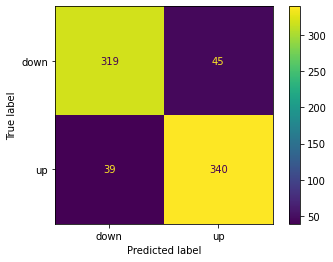

In [337]:
preds = model_both.predict(X_test)
plot = ConfusionMatrixDisplay(confusion_matrix(Y_test, preds), display_labels=['down', 'up'])
plot.plot()

In [340]:
print("Precision = {}".format(precision_score(Y_test, preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, preds)))

Precision = 0.8870891678154248
Recall = 0.8867356258517208
Accuracy = 0.8869448183041723


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

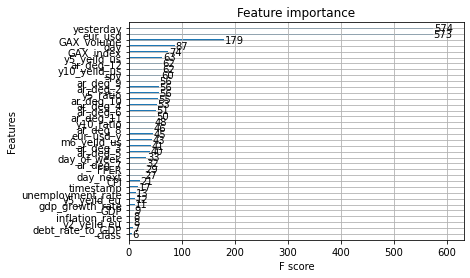

In [341]:
xgb.plot_importance(model_both)

In [344]:
# pickle.dump(model_both, open("xgb_all.pickle.dat", "wb"))

In [345]:
both['xgb_classifier'] = model_both.predict(X)

/home/tim/PycharmProjects/FOREX/venv/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



BIC --- p:  1  d:  3  q:  12  BIC:  -34453.24701897678
AIC --- p:  2  d:  3  q:  12  AIC:  -34536.94352784274
RMSE --- p:  2  d:  3  q:  12  RMSE:  0.009304483160057
0.009304483160057


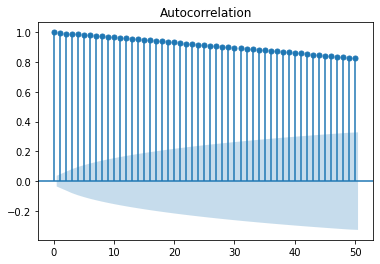

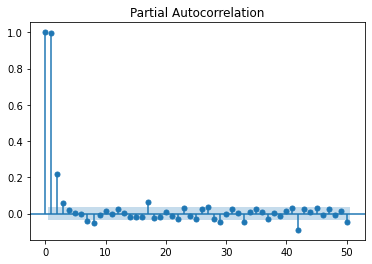

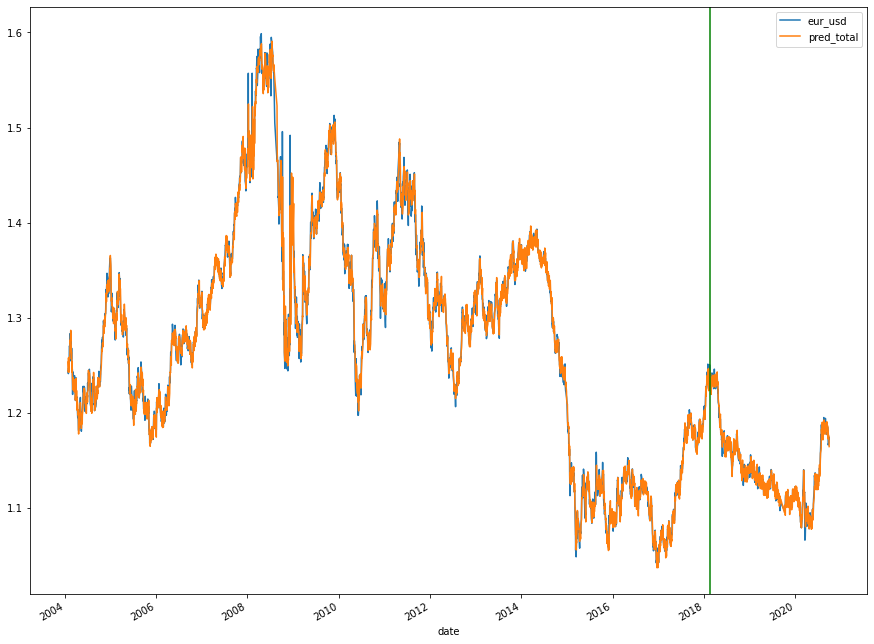

In [392]:
p3, d3, q3, aic3, xgb_out = auto_ARIMAX(both[['eur_usd', 'xgb_classifier']], exog_name='xgb_classifier', percent_training=train_portion)
xgb_out[['eur_usd', 'pred_total']].plot(figsize=(15, 12)).axvline(x = xgb_out.index[int(auto_out.shape[0] * train_portion)], color='green')
print(RMSE_(xgb_out['eur_usd'], xgb_out['pred_total']))

<AxesSubplot:xlabel='date'>

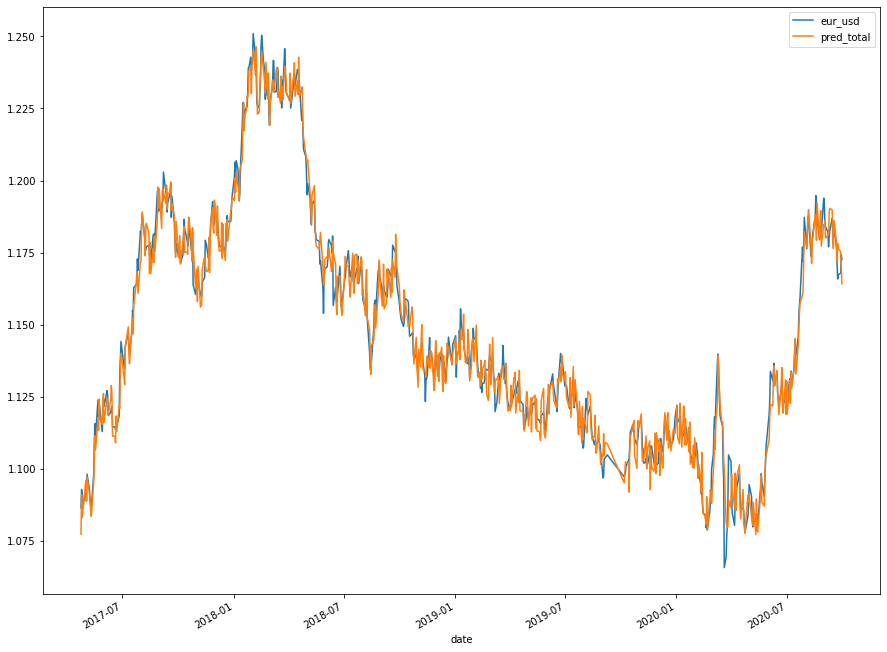

In [403]:
xgb_out[['eur_usd', 'pred_total']].iloc[int(.8 * xgb_out.shape[0]):].plot(figsize=(15, 12))

Correct direction percent:  0.9404600811907984
RMSE:  0.005287539583716726


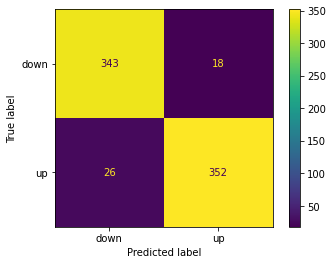

In [400]:
xgb_out = get_dir(xgb_out, train_portion=.8)

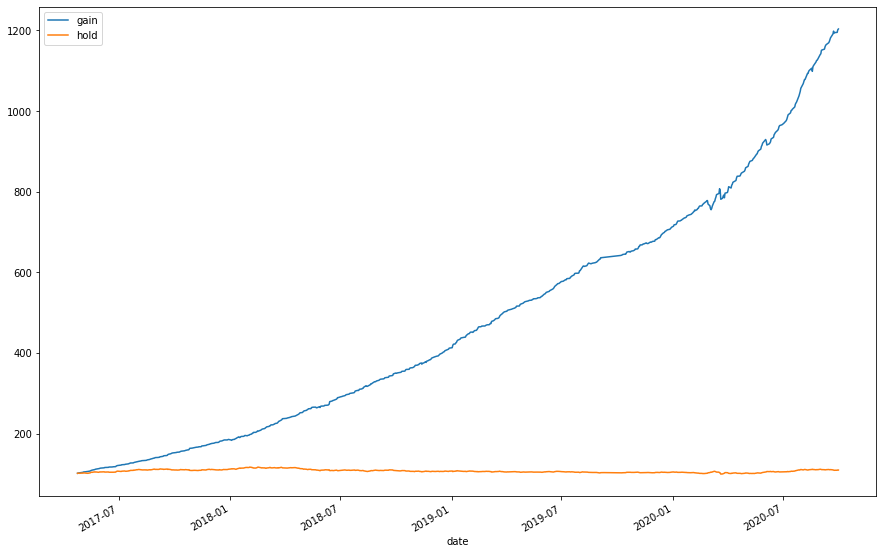

In [358]:
xgb_bt = back_test(xgb_out)

BIC --- p:  1  d:  3  q:  12  BIC:  -34479.03128629478
AIC --- p:  1  d:  3  q:  12  AIC:  -34559.82636992068
RMSE --- p:  2  d:  3  q:  12  RMSE:  0.009276511414924818
0.00928998349848545


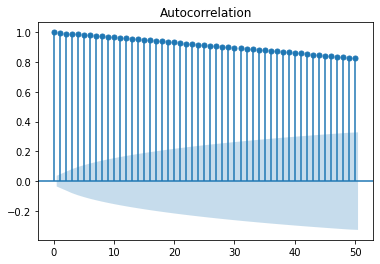

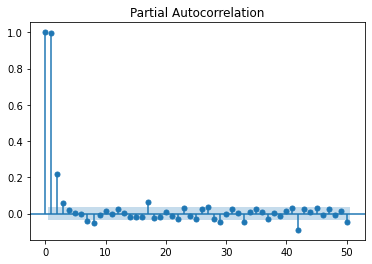

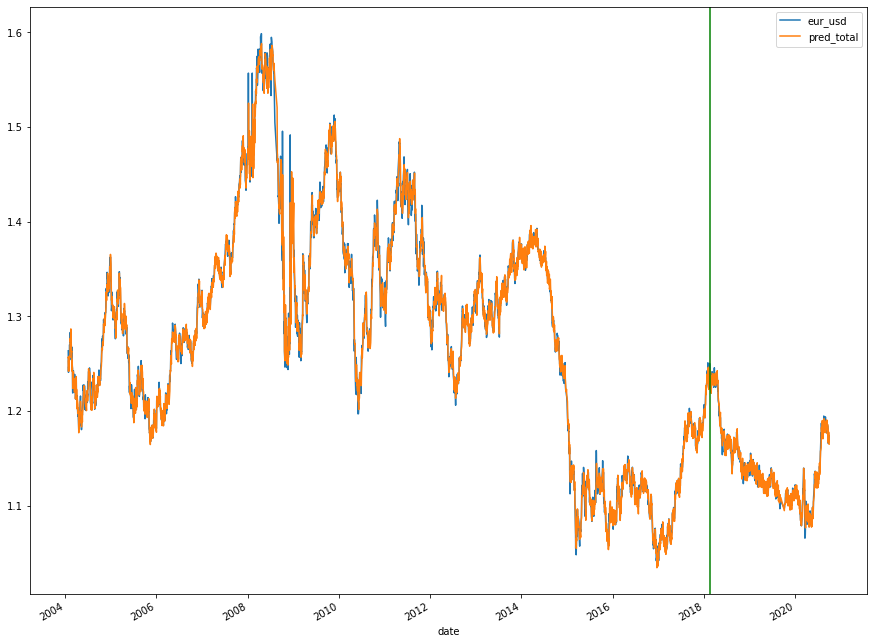

In [353]:
p3, d3, q3, aic3, dir_out = auto_ARIMAX(both[['eur_usd', 'dir']], exog_name='dir', percent_training=train_portion)
dir_out[['eur_usd', 'pred_total']].plot(figsize=(15, 12)).axvline(x = dir_out.index[int(auto_out.shape[0] * train_portion)], color='green')
print(RMSE_(dir_out['eur_usd'], dir_out['pred_total']))

Correct direction percent:  0.9566982408660352
RMSE:  0.005255812212685695


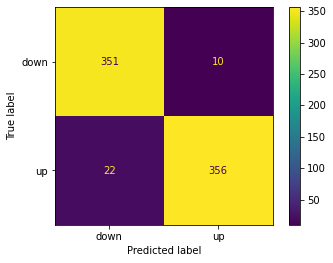

In [401]:
dir_out = get_dir(dir_out, train_portion=.8)

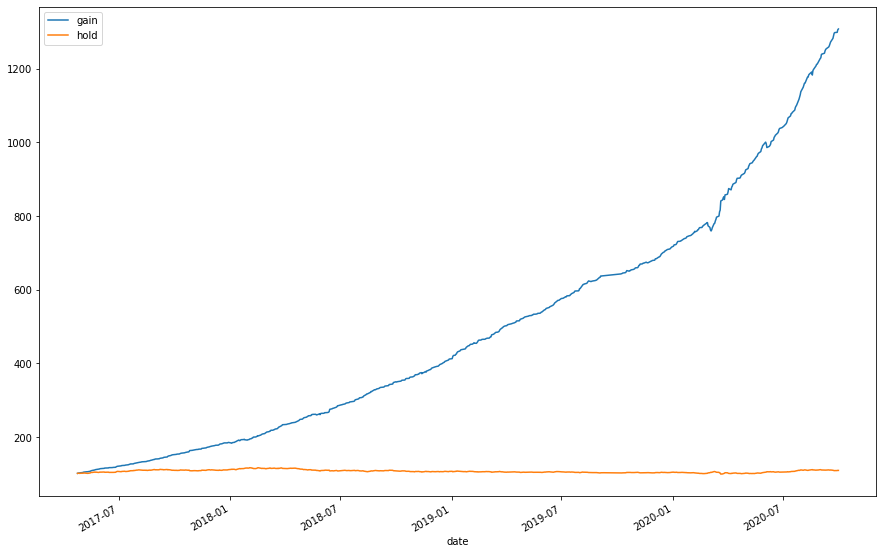

In [359]:
dir_bt = back_test(dir_out)